In [21]:
import pandas as pd
df = pd.read_excel("ABNB.xlsx")
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date').reset_index(drop=True)
df = df.dropna()
df['volatility'] = (df['high'] - df['low']) / df['close']

df['volume_prev'] = df['volume'].shift(1)
df['volatility_prev'] = df['volatility'].shift(1)

df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']

df = df.dropna()
df.to_csv("ABNB_clean.csv", index=False)

df.head()


,date,open,high,low,close,adj close,volume,volatility,volume_prev,volatility_prev,volume_delta,volatility_delta
1,2020-12-11,146.55,151.50,135.10,139.25,139.25,26980800,0.117774,70447500.0,0.164121,-43466700.0,-0.046348
2,2020-12-14,135.00,135.30,125.16,130.00,130.00,16966100,0.078000,26980800.0,0.117774,-10014700.0,-0.039774
3,2020-12-15,126.69,127.60,121.50,124.80,124.80,10914400,0.048878,16966100.0,0.078000,-6051700.0,-0.029122
4,2020-12-16,125.83,142.00,124.91,137.99,137.99,20409600,0.123850,10914400.0,0.048878,9495200.0,0.074971
5,2020-12-17,143.00,152.45,142.67,147.05,147.05,15054700,0.066508,20409600.0,0.123850,-5354900.0,-0.057342


In [18]:
df['volume_delta'] = df['volume'] - df['volume_prev']
df['volatility_delta'] = df['volatility'] - df['volatility_prev']


In [6]:
# Prepare features (X) and target (y)
volume_changes = df['volume_delta'].values.reshape(-1, 1)
volatility_changes = df['volatility_delta'].values


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Train linear model
linear_model = LinearRegression()
linear_model.fit(volume_changes, volatility_changes)

linear_predictions = linear_model.predict(volume_changes)

# R² Score
linear_r2 = r2_score(volatility_changes, linear_predictions)

# Coefficients
slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print("----- ABNB: LINEAR MODEL -----")
print(f"R² Score: {linear_r2:.4f} ({linear_r2*100:.2f}%)")
print(f"Equation: Δσ = {slope:.6e} × ΔV + {intercept:.6e}")


----- ABNB: LINEAR MODEL -----
R² Score: 0.1315 (13.15%)
Equation: Δσ = 1.580143e-09 × ΔV + -1.884263e-05


In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(volume_changes)

# Train polynomial model
poly_model = LinearRegression()
poly_model.fit(X_poly, volatility_changes)

poly_predictions = poly_model.predict(X_poly)

# R² score
r2_poly = r2_score(volatility_changes, poly_predictions)

print("\n----- ABNB: POLYNOMIAL MODEL (Degree 2) -----")
print(f"R² Score: {r2_poly:.4f} ({r2_poly*100:.2f}%)")



----- ABNB: POLYNOMIAL MODEL (Degree 2) -----
R² Score: 0.1315 (13.15%)


In [14]:
print("\n----- ABNB: MODEL COMPARISON -----")
print(f"Linear Model R²:     {linear_r2:.4f}")
print(f"Polynomial Model R²: {r2_poly:.4f}")

improvement = r2_poly - linear_r2

print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f}%)")

if r2_poly > linear_r2:
    print(f"\nPolynomial model is better by {improvement*100:.2f}%")
else:
    print("\nLinear model is actually better for ABNB.")



----- ABNB: MODEL COMPARISON -----
Linear Model R²:     0.1315
Polynomial Model R²: 0.1315

Improvement: 0.0001 (0.01%)

Polynomial model is better by 0.01%


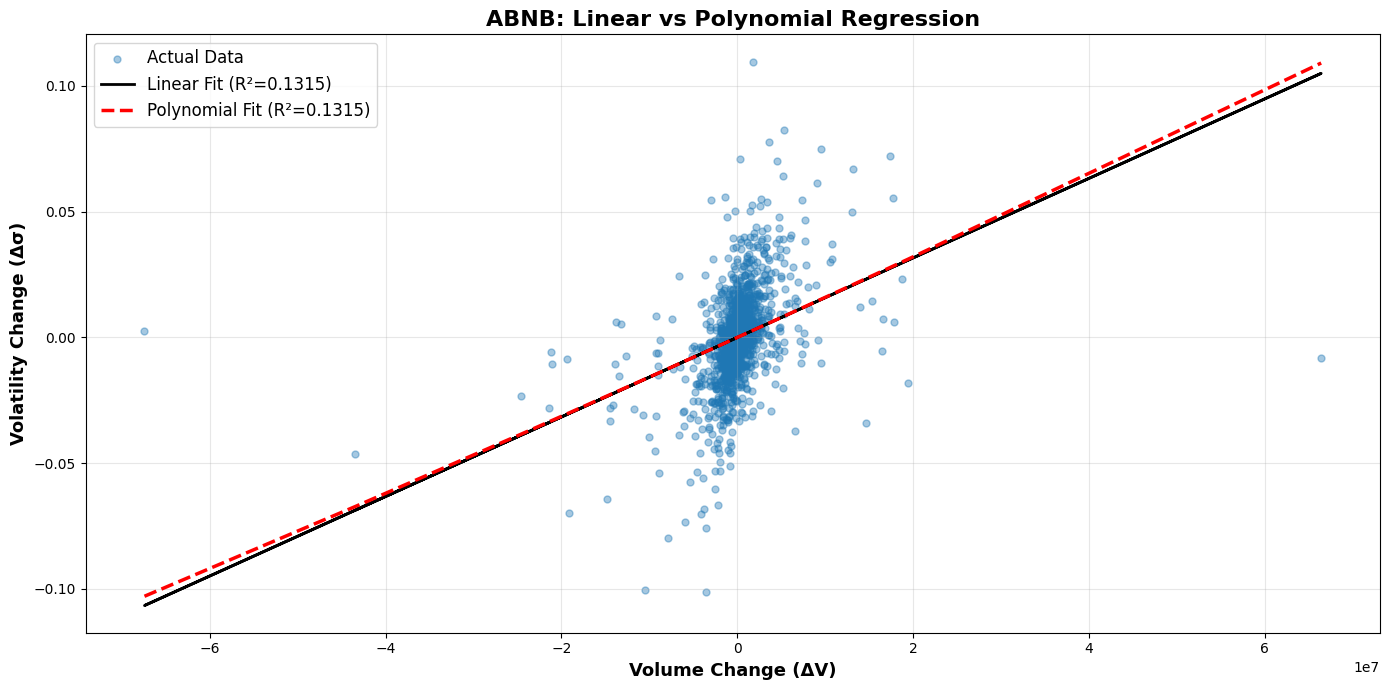

In [20]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Scatter plot
plt.scatter(
    volume_changes, volatility_changes,
    alpha=0.4, s=25, color='#1f77b4',
    label='Actual Data'
)

# Linear fit
plt.plot(
    volume_changes, linear_predictions,
    color='black', linewidth=2,
    label=f'Linear Fit (R²={linear_r2:.4f})'
)

# Sorted polynomial curve
sorted_idx = np.argsort(volume_changes.flatten())
plt.plot(
    volume_changes[sorted_idx], poly_predictions[sorted_idx],
    color='red', linewidth=2.5, linestyle='--',
    label=f'Polynomial Fit (R²={r2_poly:.4f})'
)

plt.xlabel('Volume Change (ΔV)', fontsize=13, fontweight='bold')
plt.ylabel('Volatility Change (Δσ)', fontsize=13, fontweight='bold')
plt.title('ABNB: Linear vs Polynomial Regression', fontsize=16, fontweight='bold')

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
